In [24]:
import numpy as np
import matplotlib.pyplot as plt

### Bond Price

Α bond's price is simply the sum of its discounted cash flows promised to be paid in the future. We price a coupon paid bond using the formula: $$\sum_{t=0}^{t=T} \frac{C_t}{(1+ytm)^t}+\frac{Par}{(1+ytm)^T}\boldsymbol{(1)}$$ where ytm is the annual market yield, $C_t$ is the coupon payment paid in period $t$ and $Par$ is the face value recovered at time $T$

### Bond Duration

Bond duration measures the sensitivity of the bond's price to market yields fluctuations. It can be calculated as:
$$D=\frac{\sum_{t=1/m}^{N}\frac{CF_t*t}{(1+R/m)^{mt}}}{\sum_{t=1/m}^{N}\frac{CF_t}{(1+R/m)^{mt}}}\boldsymbol{(2)}$$
which is the sum of the discounted cash flows $CF_t$ each weighted with a factor $t$ based on the period the cash flow is received divided by the price of the bond. 


### Bond class

A class that returns the price, duration, convexity and the percentage change of a bond's price by calling the appropriate methods.

In [283]:
#Creating a class for a bond that pays coupon.

class Coupon_bond:
    
    def price(self,c,par,i,n,f=1):
        total_coupons_pv,periods = self.coupons_pv(par,c, i,n,f)
        par_value_pv = self.get_par_pv(par,i,n,f)
        result = total_coupons_pv + par_value_pv
        
        return round(result,2)
    
    
    def duration(self,c,par,i,n,f=1):
        price = self.price(c,par,i,n,f)
        _, periods = self.coupons_pv(par, c, i, n, f)
        t_weights = [i+1 for i in range(n*f)]
        periods[-1]+= self.get_par_pv(par, i, n, f)
        
        duration = (sum([weight*flow for weight,flow in zip(periods,t_weights)]) / self.price(c, par, i, n))/f
        
        return duration
    
    def price_change(self,c,par,start_y,end_y,n,f=1):
        D = self.duration(c,par,start_y,n,f)
        P_elasticity = -D * (end_y - start_y) / (1+start_y) + ((end_y - start_y)**2 / 2) * self.convexity(c,par,start_y,n,f)
        
        if end_y < start_y:
            print(f'A {round(abs(end_y - start_y)*100,2)}% decrease in market yields will increase the price of the bond by approx. {round(abs(P_elasticity)*100,2)}%  ')
        else:
             print(f'A {round(abs(end_y - start_y)*100,2)}% increase in market yields will decrease the price of the bond by approx. {round(abs(P_elasticity)*100,2)}% ')
    
    
    def convexity(self,c,par,y,n,f=1):
        con_total = self.get_par_pv(par,y,n,f)*((n*f)**2+n*f)
        price = self.price(c,par,y,n,f)
        for period in range(1,n*f+1):
            con_total += self.coupon_pv(c*par,y,period,f)*(period**2 + period)
            
        result = (1 / (price*(1+y/f)**2))*con_total
    
        return result
    
    @staticmethod
    def get_par_pv(par,i,n,f):
        parpv = par / (1+i/f)**(n*f)
        return parpv
    
    
    def coupons_pv(self,par,c,i,n,f):
        total = 0
        periods = []
        for period in range(n*f):
            total += self.coupon_pv(par*c/f,i,period+1,f)
            periods.append(self.coupon_pv(par*c/f,i,period+1,f))
        return total,periods
    
    @staticmethod
    def coupon_pv(c,i,n,f):
        pv = c / (1+i/f)**(n)
        return pv
    
    

### Bond duration properties

Bonds duration has the following three properties.

1. The bond's duration $D$ increases at a decreasing rate as the maturity $M$ increases.

$$\frac{\partial D}{\partial M} > 0, \frac{\partial^2D}{\partial M^2} < 0$$

2. The bond's duration $D$ decreases as the market yields $R$ increase.

$$\frac{\partial D}{\partial R} < 0$$

3. The bond's duration $D$ decreases as the coupon payment $C$ increases.

$$\frac{\partial D}{\partial C} < 0$$

### Plotting the properties

**Property 1.**

In [4]:
#Settings x-axis range for maturity years.

maturity = np.arange(1,31,1)

#Initialize a bond by calling the bond class

bond = Coupon_bond()

#Evaluate the values for each maturity period for a €1000 par bond with 6% coupon paid annualy and 6% market yield.
duration_m = np.array([bond.duration(0.06,1000,0.06,m) for m in maturity])

We now have the data in order to plot the duration, maturity graph. However, we need to estimate and fit a curve that best describe our discrete data points in order to evaluate the first and second order partial derivatives. We do that using the numpy polyfit method.

In [5]:
#Estimating a curve that best fits the data.

#Polyfit returns the coefficients of a third order polynomial
fitted_m = np.polyfit(maturity,duration_m,3)

#Poly1d method returns the actual polynomial using the coefficients estimated above.
poly_m = np.poly1d(fitted_m)

#First order partial derivative with respect to M
f_prime_m = np.polyder(poly_m)

#Second order partial derivative with respect to M
f_dbl_prime_m = np.polyder(poly_m,m=2)



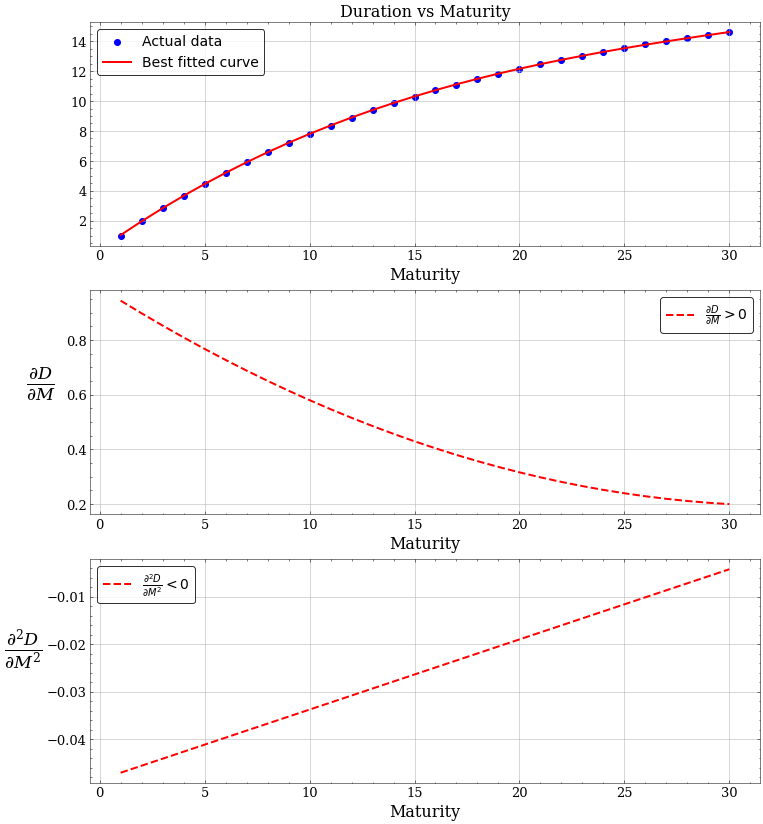

In [23]:
fig, ax = plt.subplots(3,1, figsize=(12,14))


plt.style.use(['science','notebook','no-latex'])

for i in range(len(ax)):
    ax[i].tick_params(axis='both', which='major', labelsize=13)
    ax[i].grid()
    

ax[0].scatter(maturity,duration_m, label='Actual data', color='blue')
ax[0].plot(maturity, poly_m(maturity), label='Best fitted curve', color='red')
ax[0].set_title('Duration vs Maturity')
ax[0].set_ylabel('')
ax[0].set_xlabel('Maturity')
ax[0].legend(fontsize=14,frameon=True).get_frame().set_edgecolor('#000')


ax[1].plot(maturity, f_prime_m(maturity), label=r'$\frac{\partial D}{\partial M} > 0$', color='red',linestyle='--')
ax[1].set_ylabel('')
ax[1].set_xlabel('Maturity')
ax[1].set_ylabel(r'$\frac{\partial D}{\partial M}$',fontsize=25,rotation=0,labelpad=25)
ax[1].legend(fontsize=14,frameon=True).get_frame().set_edgecolor('#000')


ax[2].plot(maturity, f_dbl_prime_m(maturity), label=r'$\frac{\partial^2 D}{\partial M^2} < 0$', color='red',linestyle='--')
ax[2].set_ylabel(r'$\frac{\partial^2 D}{\partial M^2}$',fontsize=25,rotation=0,labelpad=24)
ax[2].set_xlabel('Maturity')
ax[2].legend(fontsize=14,frameon=True).get_frame().set_edgecolor('#000')


**Property 2.**

In [7]:
#Settings x-axis range for yields for the same characteristics bond.

yields = np.arange(0.01,0.31,0.01)

duration_y = np.array([bond.duration(0.06,1000,y,10) for y in yields])


In [8]:
#Estimating a curve that best fits the data.

#Polyfit returns the coefficients of a second order polynomial
fitted_y = np.polyfit(yields,duration_y,2)

#Poly1d method returns the actual polynomial using the coefficients estimated above.
poly_y = np.poly1d(fitted_y)

#First order partial derivative with respect to M
f_prime_y = np.polyder(poly_y)


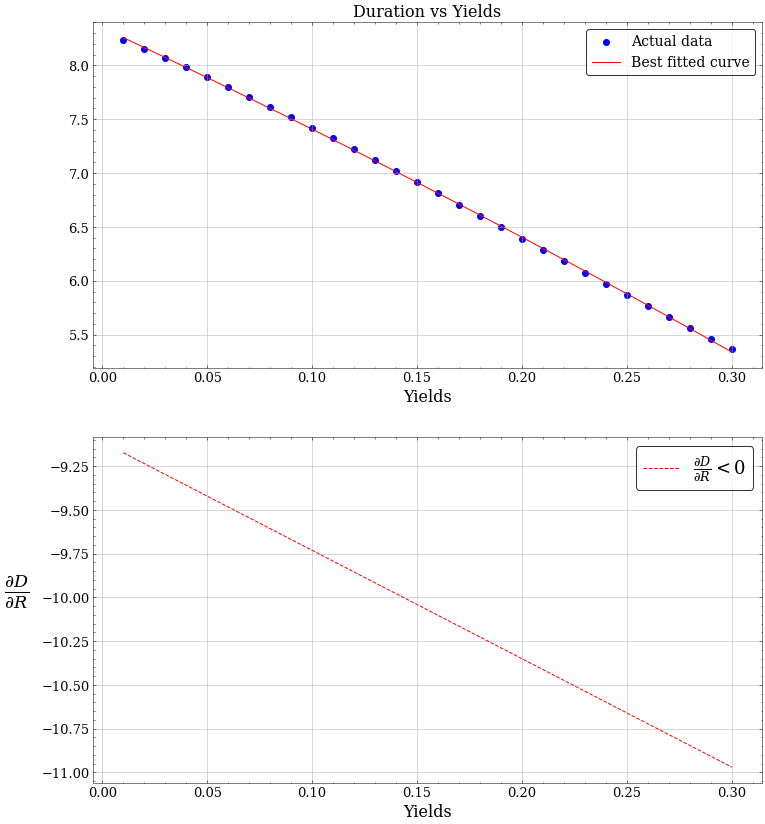

In [22]:
fig, ax = plt.subplots(2,1, figsize=(12,14))



plt.style.use(['science','no-latex'])

for i in range(len(ax)):
    ax[i].tick_params(axis='both', which='major', labelsize=13)
    ax[i].grid()
    

ax[0].scatter(yields,duration_y, label='Actual data', color='blue')
ax[0].plot(yields, poly_y(yields), label='Best fitted curve', color='red')
ax[0].set_title('Duration vs Yields')
ax[0].set_ylabel('')
ax[0].set_xlabel('Yields')
ax[0].legend(fontsize=14,frameon=True).get_frame().set_edgecolor('#000')


ax[1].plot(yields, f_prime_y(yields), label=r'$\frac{\partial D}{\partial R} < 0$', color='red',linestyle='--')
ax[1].set_ylabel(r'$\frac{\partial D}{\partial R}$',fontsize=25,rotation=0,labelpad=25)
ax[1].set_xlabel('Yields')
ax[1].legend(fontsize=18, frameon=True).get_frame().set_edgecolor('#000')



**Property 3.**

In [10]:
#Settings x-axis range for coupon.

coupon = np.arange(0.01,0.31,0.01)

duration_c = np.array([bond.duration(c,1000,0.06,10) for c in coupon])

In [11]:
#Estimating a curve that best fits the data.

#Polyfit returns the coefficients of a fourth order polynomial
fitted_c = np.polyfit(coupon,duration_c,4)

#Poly1d method returns the actual polynomial using the coefficients estimated above.
poly_c = np.poly1d(fitted_c)

#First order partial derivative with respect to M
f_prime_c = np.polyder(poly_c)

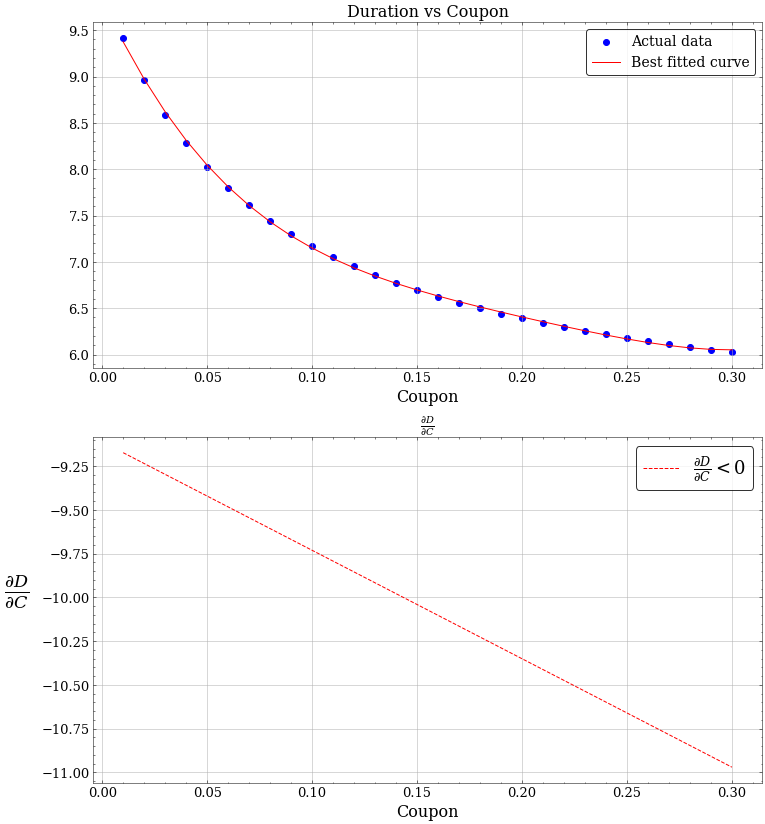

In [21]:
fig, ax = plt.subplots(2,1, figsize=(12,14))

plt.style.use(['science','no-latex'])

for i in range(len(ax)):
    ax[i].tick_params(axis='both', which='major', labelsize=13)
    ax[i].grid()

ax[0].scatter(coupon,duration_c, label='Actual data', color='blue')
ax[0].plot(coupon, poly_c(coupon), label='Best fitted curve', color='red')
ax[0].set_title('Duration vs Coupon')
ax[0].set_ylabel('')
ax[0].set_xlabel('Coupon')
ax[0].legend(fontsize=14,frameon=True).get_frame().set_edgecolor('#000')


ax[1].plot(yields, f_prime_y(yields), label=r'$\frac{\partial D}{\partial C} < 0$', color='red',linestyle='--')
ax[1].set_title(r'$\frac{\partial D}{\partial C}$',fontsize=14)
ax[1].set_ylabel(r'$\frac{\partial D}{\partial C}$',fontsize=25,rotation=0,labelpad=25)
ax[1].set_xlabel('Coupon')
ax[1].legend(fontsize=18, frameon=True).get_frame().set_edgecolor('#000')

**Error when using duration to estimate bond price changes to market yields fluctuation**

By taking the derivative $\frac{dP}{dR}$ of equation $(1)$ and combine it with equation $(2)$ of the duration of a bond, it can be shown that bond price elasticity to yield changes $(ΔR)$ can be described by the following formula.  $$\frac{ΔP}{P}= -Duration(\frac{ΔR}{1+R})\boldsymbol{(3)}$$ 

Equation 3 can be used to estimate the percentage change of a price of a bond when $ΔR$ is small. If $ΔR$ however is large then an estimation error occurs. The reason for this is the assumption of linearity. While in Eq. 3 we assume a linear price yield relationship, in reality we observe a non linear convex one.

Assume a 30 year $1000 par bond that pays 8% coupon semi-annually. We can plot the behavior of this bond's price to different yields.

In [286]:
#Setting the yields range

y_range = np.arange(0.01,0.21,0.01)

#Initialize a bond using the Coupon bond class
bond10c8 = Coupon_bond()

#prices of the bond for the y_range

prices = [bond10c8.price(0.08,1000,y,30,2) for y in y_range]



**Plotting the price yield curve**

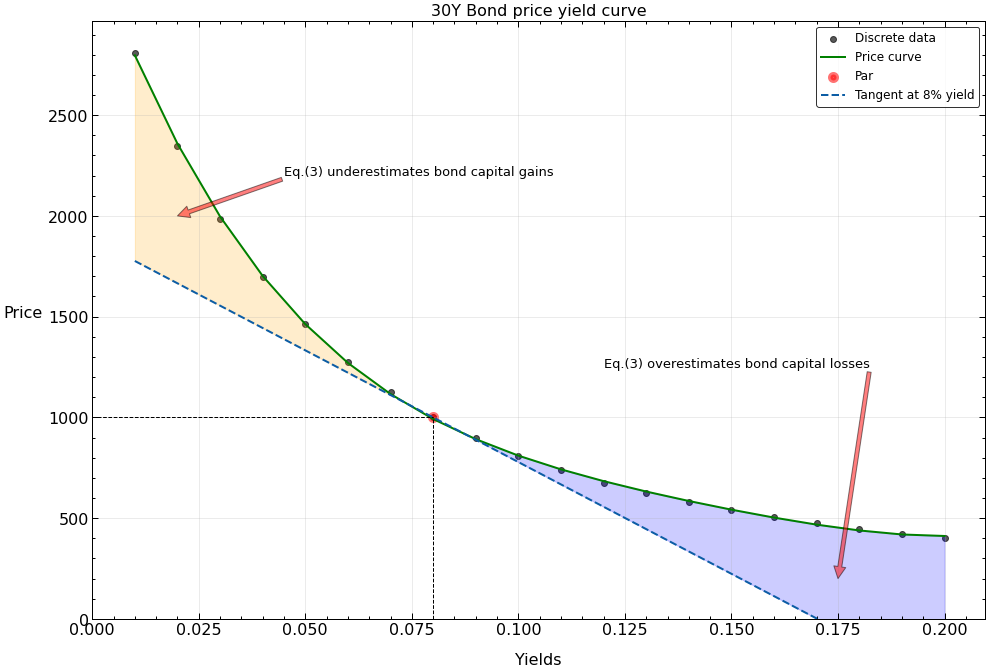

In [289]:
fig, ax = plt.subplots(figsize=(16,11))


#Based on the discrete data above, we can fit a curve which best represents the bond price yield relationship.
curve = np.polyfit(y_range,prices,4)
poly = np.poly1d(curve)


ax.scatter(y_range, prices,alpha=0.65,label='Discrete data',c='black')
ax.plot(y_range,poly(y_range),c='green',label='Price curve')
ax.set_title('30Y Bond price yield curve')
ax.set_xlabel('Yields',labelpad=15)
ax.set_ylabel('Price',rotation=0,labelpad=25)


ax.scatter(0.08,1000,alpha=0.55,label='Par',c='red',linewidth=5)

#Assumg that market yields are currently at 6% hence we're at par. 

#First derivative of the curve
slope = np.polyder(poly,1)

tangent_range = np.arange(0.01,0.20,0.01)

def tangent(x):
    return slope(0.08)*(x-0.08)+1000

ax.plot(tangent_range,tangent(tangent_range),linestyle='--',label='Tangent at 8% yield')
ax.fill_between(y_range,tangent(y_range),poly(y_range),where=(tangent(y_range) > 1000),color='orange',alpha=0.2)
ax.fill_between(y_range,tangent(y_range),poly(y_range),where=(tangent(y_range) < 1000), color='blue',alpha=0.2)
ax.set_ylim(bottom=0)
ax.set_xlim(left=0)
ax.vlines(0.08,-600,1000, linestyle='--' ,linewidth=1,color='black')
ax.hlines(1000,0,0.08,linestyle='--',linewidth=1,color='black')
ax.annotate('Eq.(3) underestimates bond capital gains',xy=(0.02,2000),xytext=(0.045,2200),fontsize=13,arrowprops=dict(facecolor='red', alpha=0.50))
ax.annotate('Eq.(3) overestimates bond capital losses',xy=(0.175,200),xytext=(0.12,1250),fontsize=13,arrowprops=dict(facecolor='red', alpha=0.50))
ax.grid(alpha=0.25)
ax.legend(fontsize=12,frameon=True).get_frame().set_edgecolor('#000')

**Convexity adjustment**

Equation $(3)$ can be adjusted in order to account for the convexity. The formula becomes: $$\frac{ΔP}{P}= -Duration(\frac{ΔR}{1+R})+\frac{(ΔR)^2}{2}Convexity$$ where $$Convexity=\frac{1}{P(1+R)^2}\sum_{t=1}^{T}\frac{CF_t}{(1+R)^t}(t^2+t)$$

**Example**

Estimate the price change of a 10-year $1,000 par bond that pays 6% semi-annual coupon when market yields increase by 100bps from 6 to 7%.

In [285]:
#We initialize a bond via the bond class

Bond10Y = Coupon_bond()

#Calling the price_change method. // price_change(self,c,par,start_y,end_y,n,f=1)//
Bond10Y.price_change(0.06,1000,0.06,0.07,10,2)

A 1.0% increase in market yields will decrease the price of the bond by approx. 5.57% 
